In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from sqlalchemy import create_engine
from config import username, password

engine = create_engine('postgresql://{}:{}@localhost:5432/cali_renewable_db'.format(username,password))
con = engine.connect()

sql_prod = '''Select * From  "Production".hourlyrenewable'''

full_data = pd.read_sql(sql=sql_prod,con=con)
full_data['date'] = pd.to_datetime(full_data['date'])

display(full_data.head())

sql_demand = 'Select * From "Demand".hourlydemand'
demand_data = pd.read_sql(sql=sql_demand, con=con)

demand_data['date'] = pd.to_datetime(demand_data['date'])
demand_data['YEAR'] = demand_data['date'].dt.year

demand_data.head()

timestamp       date  Hour  TOTAL  SOLAR TOTAL  SOLAR PV  \
0 2015-06-01 00:00:00 2015-06-01     1   4669            0         0   
1 2015-06-01 01:00:00 2015-06-01     2   4396            0         0   
2 2015-06-01 02:00:00 2015-06-01     3   4197            0         0   
3 2015-06-01 03:00:00 2015-06-01     4   4059            0         0   
4 2015-06-01 04:00:00 2015-06-01     5   3694            0         0   

   SOLAR THERMAL  WIND TOTAL  GEOTHERMAL  BIOMASS  BIOGAS  SMALL HYDRO  
0              0        2942        1038      321     209          159  
1              0        2708        1040      316     210          122  
2              0        2509        1039      319     209          121  
3              0        2372        1035      320     209          123  
4              0        1973        1035      317     208          161

timestamp       date  Hour   DEMAND  YEAR
0 2019-12-29 11:00:00 2019-12-29    11  21305.0  2019
1 2019-12-29 10:00:00 2019-12-29    10  21638.0  2019
2 2019-12-29 09:00:00 2019-12-29     9  21745.0  2019
3 2019-12-29 08:00:00 2019-12-29     8  21859.0  2019
4 2019-12-29 07:00:00 2019-12-29     7  21586.0  2019

In [2]:
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

In [3]:
#still messing around with extra regressors 



full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

scaler = StandardScaler()

dd['cap'] = 17000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

ds         y       cap  on_season  off_season   daytime  \
0 2015-06-01 00:00:00  8.448700  9.740969       True       False -0.795932   
1 2015-06-01 01:00:00  8.388450  9.740969       True       False -0.795932   
2 2015-06-01 02:00:00  8.342125  9.740969       True       False -0.795932   
3 2015-06-01 03:00:00  8.308692  9.740969       True       False -0.795932   
4 2015-06-01 04:00:00  8.214465  9.740969       True       False -0.795932   
5 2015-06-01 05:00:00  8.228978  9.740969       True       False -0.795932   
6 2015-06-01 06:00:00  8.365905  9.740969       True       False -0.795932   
7 2015-06-01 07:00:00  8.716372  9.740969       True       False -0.795932   

   on_seasonr  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


In [4]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=.5,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=6)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [5]:
future = model.make_future_dataframe(periods=365*24,freq='1H')
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 20000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)

forcast = model.predict(future)

ds     trend       cap  yhat_lower  yhat_upper  \
0 2015-06-01 00:00:00  8.390555  9.903488    8.142069    8.753151   
1 2015-06-01 01:00:00  8.390567  9.903488    8.099363    8.726640   
2 2015-06-01 02:00:00  8.390580  9.903488    8.098113    8.684478   
3 2015-06-01 03:00:00  8.390593  9.903488    8.074412    8.665629   
4 2015-06-01 04:00:00  8.390605  9.903488    8.020078    8.601583   

   trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0     8.390555     8.390555        0.049006              0.049006   
1     8.390567     8.390567        0.024177              0.024177   
2     8.390580     8.390580        0.008371              0.008371   
3     8.390593     8.390593       -0.009136             -0.009136   
4     8.390605     8.390605       -0.068242             -0.068242   

   additive_terms_upper  ...  on_seasonr  on_seasonr_lower  on_seasonr_upper  \
0              0.049006  ...    0.085787          0.085787          0.085787   
1              0.024177  ...    0.085787          0.085787          0.085787   
2              0.008371  ...    0.085787          0.085787          0.085787   
3             -0.009136  ...    0.085787          0.085787          0.085787   
4             -0.068242  ...    0.085787          0.085787          0.085787   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  0.354122      0.354122      0.354122                   0.0   
1  0.351800      0.351800      0.351800                   0.0   
2  0.349356      0.349356      0.349356                   0.0   
3  0.346812      0.346812      0.346812                   0.0   
4  0.344191      0.344191      0.344191                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  8.439561  
1                         0.0                         0.0  8.414745  
2                         0.0                         0.0  8.398951  
3                         0.0                         0.0  8.381456  
4                         0.0                         0.0  8.322364  

[5 rows x 32 columns]

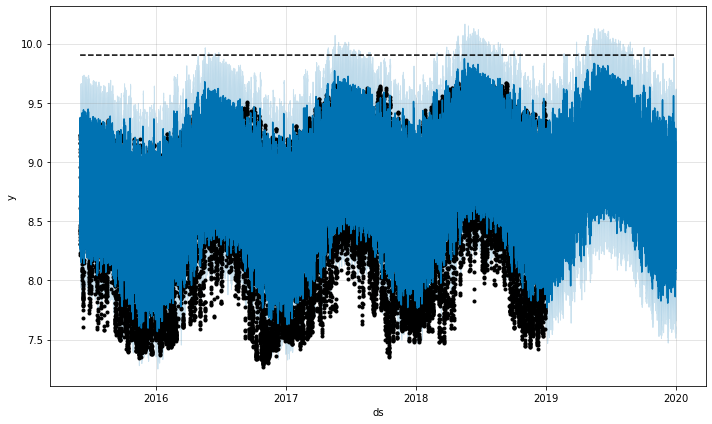

In [6]:
model.plot(forcast)
forcast.head()


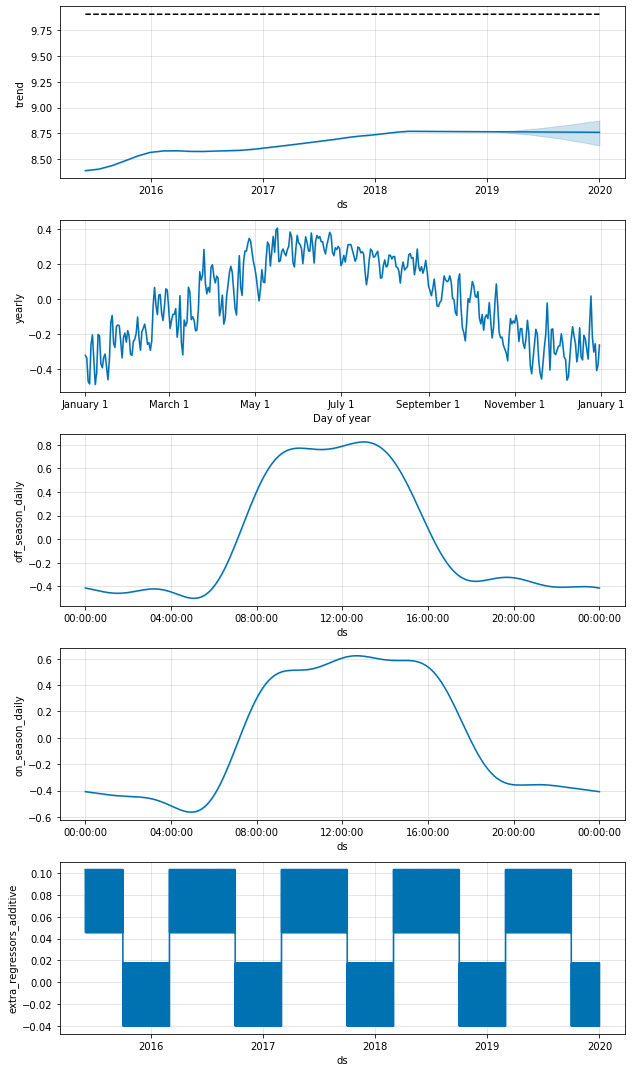

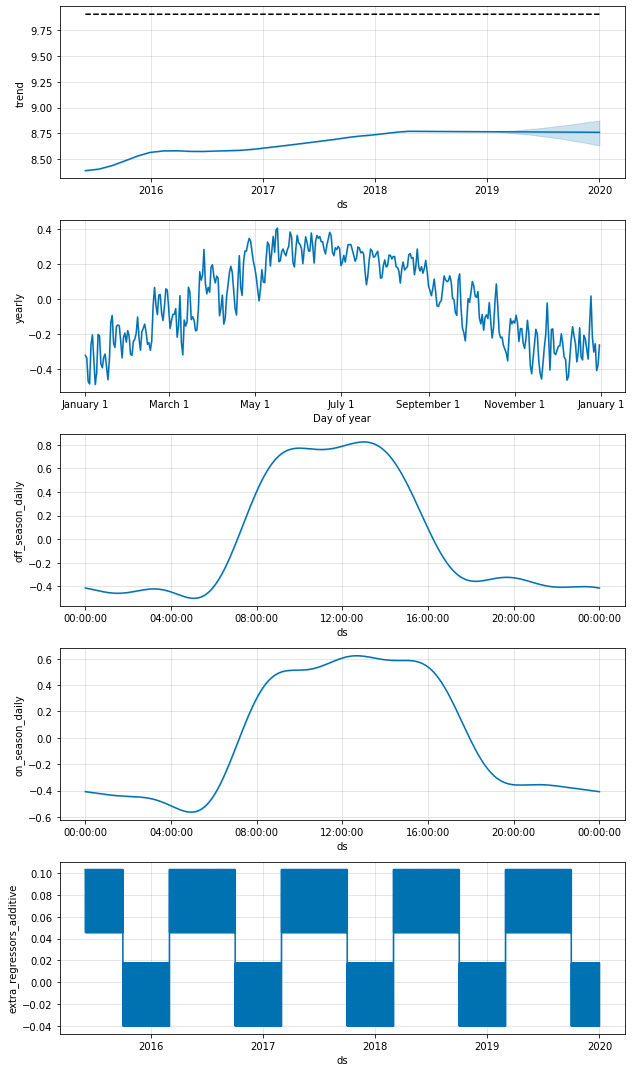

In [7]:
model.plot_components(forcast)

In [8]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

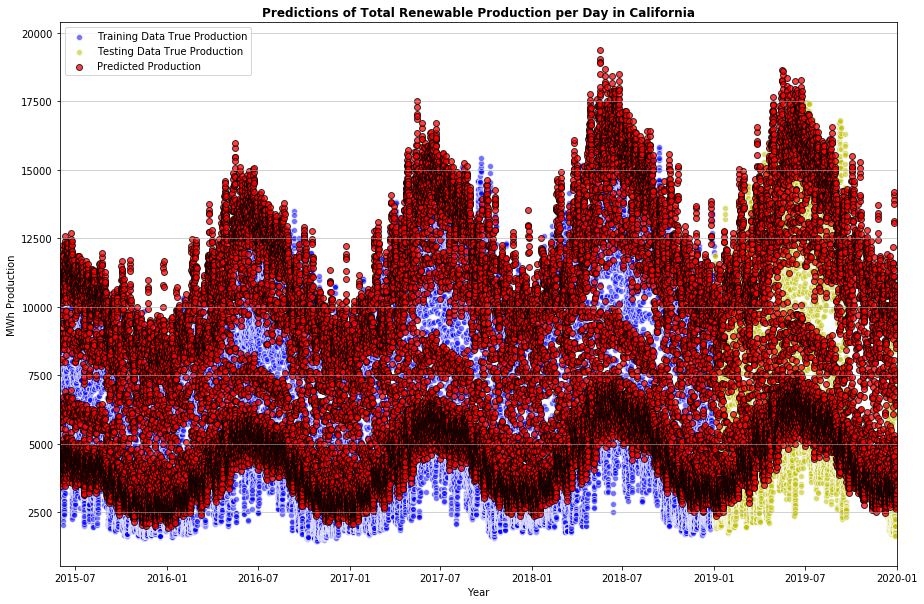

In [9]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  53355.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  5068.0


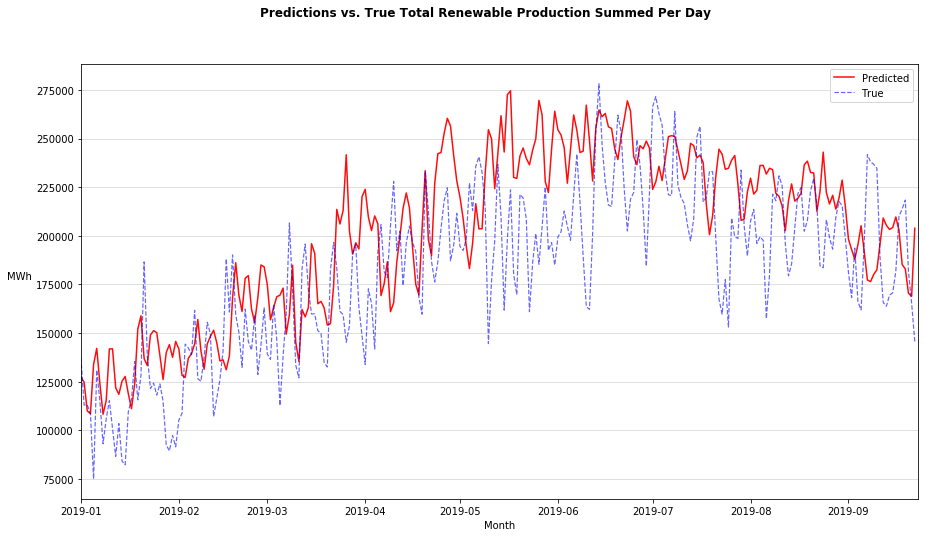

Train MAPE:  24.694884236900826
Train R2:  0.7917331334018998
Test MAPE:  25.127370592364183
Test R2:  0.7864695629052734


In [10]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])
#test data predictions and true values
tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)

#for plotting
dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values


#for plotting
datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'y'].values


month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))

plt.show()

#for calculations, training data
yhat_train = pd.DataFrame(forcast.loc[(forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[(dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])
#combine above two into one for calculations on training data 
tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [11]:
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['SOLAR TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd_s = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month > 3) & (date.month < 11)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 10:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1



dd_s.columns = ['ds','y']

scaler = StandardScaler()

dd_s['cap'] = np.cbrt(15000)
dd_s['floor'] = 0
#dd_s['cap'] = np.log(dd['cap'])

dd_s['on_season'] = dd_s['ds'].apply(on_season)
dd_s['off_season'] = ~dd_s['ds'].apply(on_season)
dd_s['daytime'] = dd_s['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd_s['on_seasonr'] = dd_s['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
#dd['y'] = dd['y'].replace(0,dd['y'].median())
dd_s['y'] = np.cbrt(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
#dd_s['y'] = np.log(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd_s['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd_s['daytime'] = scaler.fit_transform(daytimev)

dd_s_train = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2016'))&(dd_s['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_s_train.head(8))

dd_s_train.info()

ds         y        cap  floor  on_season  off_season  \
5136 2016-01-01 00:00:00  0.000000  24.662121      0      False        True   
5137 2016-01-01 01:00:00  0.000000  24.662121      0      False        True   
5138 2016-01-01 02:00:00  0.000000  24.662121      0      False        True   
5139 2016-01-01 03:00:00  0.000000  24.662121      0      False        True   
5140 2016-01-01 04:00:00  0.000000  24.662121      0      False        True   
5141 2016-01-01 05:00:00  0.000000  24.662121      0      False        True   
5142 2016-01-01 06:00:00  0.000000  24.662121      0      False        True   
5143 2016-01-01 07:00:00  9.020529  24.662121      0      False        True   

       daytime  on_seasonr  
5136 -0.816497           0  
5137 -0.816497           0  
5138 -0.816497           0  
5139 -0.816497           0  
5140 -0.816497           0  
5141 -0.816497           0  
5142 -0.816497           0  
5143 -0.816497           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
ds            26256 non-null datetime64[ns]
y             26256 non-null float64
cap           26256 non-null float64
floor         26256 non-null int64
on_season     26256 non-null bool
off_season    26256 non-null bool
daytime       26256 non-null float64
on_seasonr    26256 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.5 MB


In [12]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.01,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=10,prior_scale=1)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=10,prior_scale=1)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
#model.add_regressor('daytime',standardize=False)
#model.add_regressor('equinox')
#model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_s_train)



In [13]:
futures = model.make_future_dataframe(periods=365*24,freq='1H')
futures['on_season'] = futures['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
futures['off_season'] = ~futures['ds'].apply(on_season)
futures['daytime'] = futures['ds'].apply(daytime)
futures['on_seasonr'] = futures['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
futures['cap'] = np.cbrt(15000)
futures['floor'] = 0
#futures['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = futures['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
futures['daytime'] = scaler.fit_transform(daytimef)

forcasts = model.predict(futures)

ds     trend        cap  floor  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  9.216877  24.662121      0   -2.591267    1.703881   
35012 2019-12-31 20:00:00  9.216895  24.662121      0   -3.028043    1.615413   
35013 2019-12-31 21:00:00  9.216914  24.662121      0   -3.002265    1.965804   
35014 2019-12-31 22:00:00  9.216932  24.662121      0   -3.087196    1.469139   
35015 2019-12-31 23:00:00  9.216950  24.662121      0   -2.893907    1.642969   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  ...  \
35011     9.065411     9.371192       -9.569550             -9.569550  ...   
35012     9.065405     9.371236       -9.975978             -9.975978  ...   
35013     9.065398     9.371279       -9.755797             -9.755797  ...   
35014     9.065392     9.371323      -10.013413            -10.013413  ...   
35015     9.065388     9.371366       -9.879702             -9.879702  ...   

       on_season_daily  on_season_daily_lower  on_season_daily_upper  \
35011              0.0                    0.0                    0.0   
35012              0.0                    0.0                    0.0   
35013              0.0                    0.0                    0.0   
35014              0.0                    0.0                    0.0   
35015              0.0                    0.0                    0.0   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
35011 -3.048518     -3.048518     -3.048518                   0.0   
35012 -3.038002     -3.038002     -3.038002                   0.0   
35013 -3.023224     -3.023224     -3.023224                   0.0   
35014 -3.004392     -3.004392     -3.004392                   0.0   
35015 -2.981745     -2.981745     -2.981745                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper      yhat  
35011                         0.0                         0.0 -0.352673  
35012                         0.0                         0.0 -0.759082  
35013                         0.0                         0.0 -0.538883  
35014                         0.0                         0.0 -0.796482  
35015                         0.0                         0.0 -0.662752  

[5 rows x 24 columns]

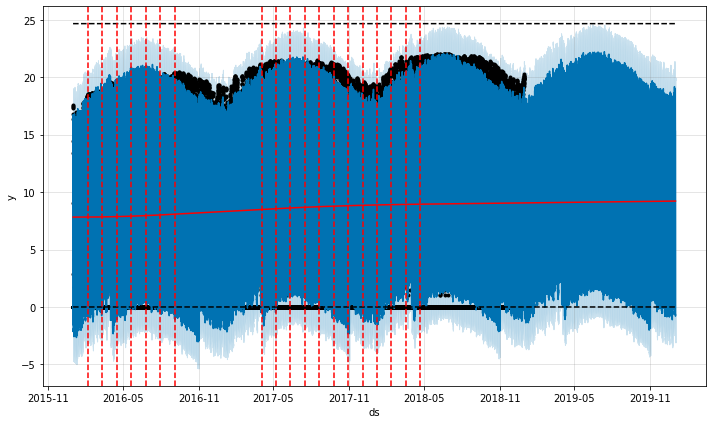

In [14]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forcasts)
a = add_changepoints_to_plot(fig.gca(), model, forcasts)
forcasts.tail()

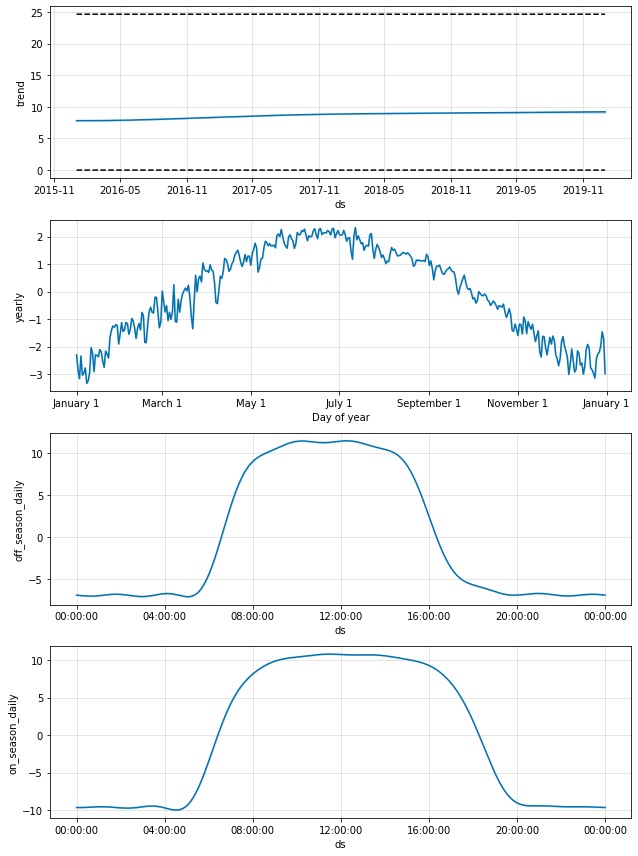

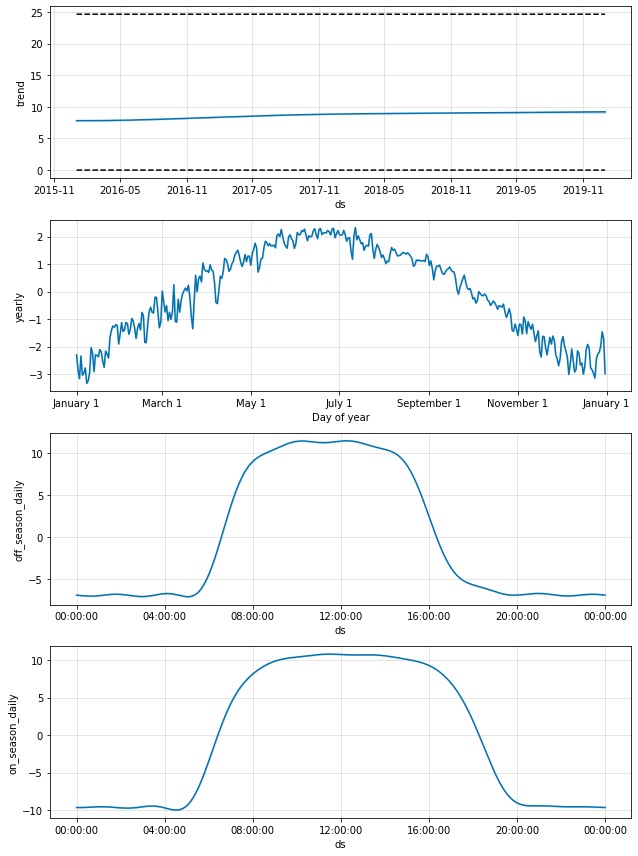

In [15]:
model.plot_components(forcasts)

In [16]:
#dd_s['y'] = np.exp(dd['y'])
dd_s['y'] = (dd_s['y'])**3
#dd_s_train['y'] = np.exp(dd_s_train['y'])
dd_s_train['y'] = (dd_s_train['y'])**3
#forcasts['yhst'] = np.exp(forcast['yhat'])
forcasts['yhat'] = (forcasts['yhat'])**3
dd_s_test = dd_s.loc[dd_s['ds']>pd.to_datetime('01/01/2019')]

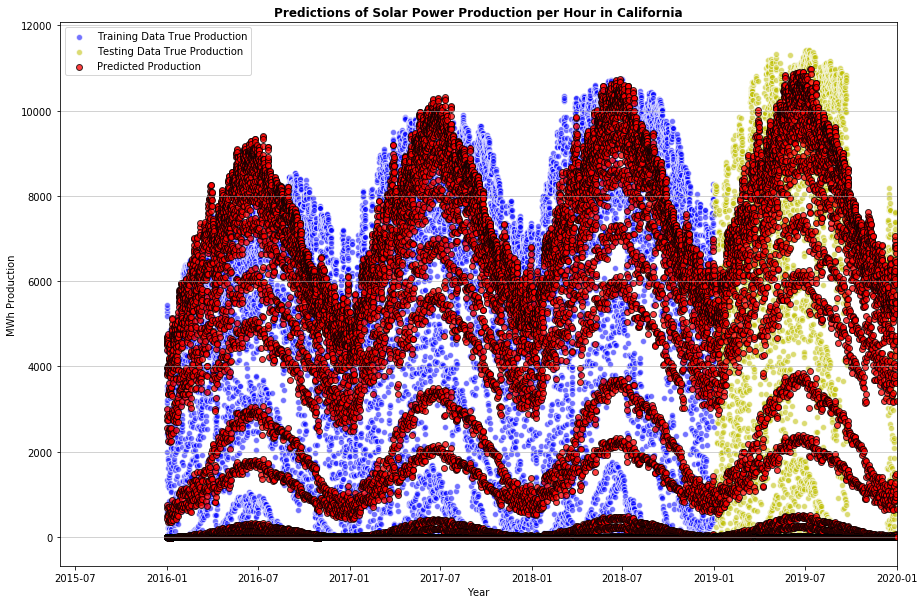

In [17]:

plt.figure(figsize=(15,10))

plt.scatter(dd_s_train['ds'],dd_s_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_s_test['ds'],dd_s_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcasts['ds'],forcasts['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.show()

Predicted total solar Production 2017:  20631.0
True total solar Production 2017:  22684.0
Error in year total prediction in GWh:  -2053.0


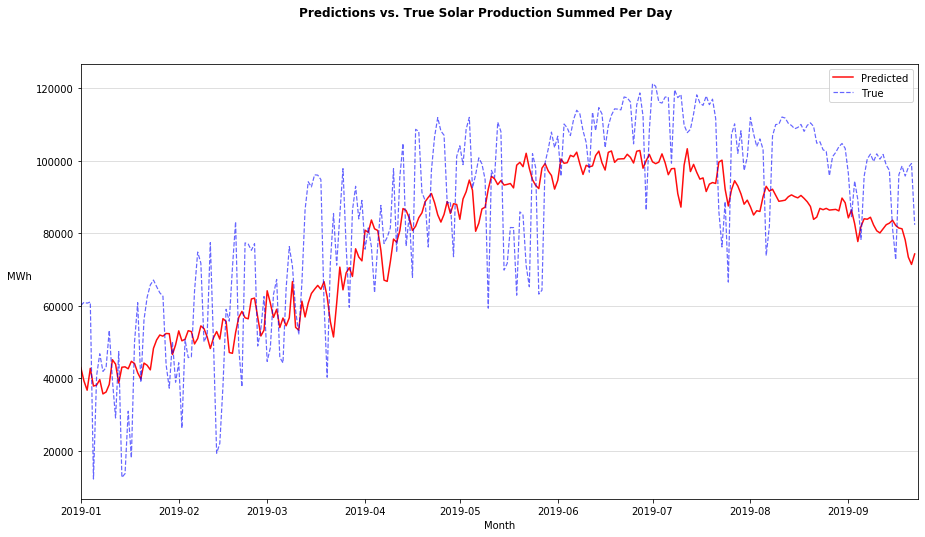

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning:

divide by zero encountered in double_scalars



Test MAPE:  inf
Train R2:  0.9382492140591896
Test MAPE:  inf
Test R2:  0.913177693564305


C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning:

divide by zero encountered in double_scalars



In [18]:
yhats = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
trues = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

testers = pd.merge(yhats.set_index(pd.DatetimeIndex(yhats['ds'])),(trues.set_index(pd.DatetimeIndex(trues['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted total solar Production 2017: ',(testers['yhat'].sum())//1000)
print('True total solar Production 2017: ',testers['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (testers['yhat'].sum()-testers['y'].sum())//1000)


datafs = forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                       (forcasts['ds'] < pd.to_datetime('09/23/2019'))),:].\
set_index(pd.DatetimeIndex(forcasts.loc[((forcasts['ds'] >= pd.to_datetime\
                                          ('01/01/2019')) & (forcasts['ds'] \
                                                             < pd.to_datetime\
                                                             ('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datats = dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                   (dd_s['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd_s['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'y'].values

month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,datafs,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datats,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Solar Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
#plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_trains = pd.DataFrame(forcasts.loc[\
                                         (forcasts['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_trains = pd.DataFrame(dd_s.loc[\
                                     (dd_s['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_trains = pd.merge(yhat_trains.set_index(pd.DatetimeIndex(yhat_trains['ds'])),(true_trains.set_index(pd.DatetimeIndex(true_trains['ds']))),how='left',left_index=True,right_index=True)


tester_trains['msem'] = ((tester_trains['y']-tester_trains['yhat'])**2)
tester_trains['mseb'] = (tester_trains['y']-tester_trains['y'].mean())**2
r2 = 1 - ((np.sum(tester_trains['msem'])/len(tester_trains))/(np.sum(tester_trains['mseb'])/len(tester_trains)))
true_trains = tester_trains['y'].values
yhat_trains = tester_trains['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/np.nan_to_num(true))),true_trains,yhat_trains)))*(100/len(true_trains))
print('Test MAPE: ', mape)
print('Train R2: ',r2)


testers['msem'] = ((testers['y']-testers['yhat'])**2)
testers['mseb'] = (testers['y']-testers['y'].mean())**2
r2 = 1 - ((np.sum(testers['msem'])/len(testers))/(np.sum(testers['mseb'])/len(testers)))
true_tests = testers['y'].values
yhat_tests = testers['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_tests,yhat_tests)))))*100)/len(true_tests)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [19]:
 
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']

daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 4) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

dd_sm = forcasts.loc[:,['ds','yhat']]
print('''forcasts.loc[:,['ds','yhat']].head()''')
display(forcasts.loc[:,['ds','yhat']].head())

dd = pd.merge(dd.set_index(pd.DatetimeIndex(dd['ds'])),(dd_sm.set_index(pd.DatetimeIndex(dd_sm['ds']))),
              how='left',left_index=True,right_index=True)
dd = dd.reset_index()
dd.drop(columns=['ds_x','ds_y'],inplace=True)
dd.columns = ['ds','y','solar']
display(dd.head())


scaler = StandardScaler()

dd['cap'] = 25000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_seasonr'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

solarv = dd['solar'].values
solarv = solarv.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)
dd['solar'] = scaler.fit_transform(solarv)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2016'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

forcasts.loc[:,['ds','yhat']].head()


ds      yhat
0 2016-01-01 00:00:00 -8.844595
1 2016-01-01 01:00:00 -9.451883
2 2016-01-01 02:00:00 -7.031421
3 2016-01-01 03:00:00 -9.868032
4 2016-01-01 04:00:00 -5.453305

ds     y  solar
0 2015-06-01 00:00:00  4669    NaN
1 2015-06-01 01:00:00  4396    NaN
2 2015-06-01 02:00:00  4197    NaN
3 2015-06-01 03:00:00  4059    NaN
4 2015-06-01 04:00:00  3694    NaN

ds         y     solar        cap  on_season  \
5136 2016-01-01 00:00:00  7.942007 -0.808571  10.126631      False   
5137 2016-01-01 01:00:00  7.929487 -0.808746  10.126631      False   
5138 2016-01-01 02:00:00  7.909122 -0.808050  10.126631      False   
5139 2016-01-01 03:00:00  7.920083 -0.808866  10.126631      False   
5140 2016-01-01 04:00:00  7.945910 -0.807596  10.126631      False   
5141 2016-01-01 05:00:00  7.919720 -0.808635  10.126631      False   
5142 2016-01-01 06:00:00  7.916807 -0.805974  10.126631      False   
5143 2016-01-01 07:00:00  8.101072 -0.612553  10.126631      False   

      off_season   daytime  on_seasonr  
5136        True -0.795932           0  
5137        True -0.795932           0  
5138        True -0.795932           0  
5139        True -0.795932           0  
5140        True -0.795932           0  
5141        True -0.795932           0  
5142        True -0.795932           0  
5143        True -0.795932           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
ds            26256 non-null datetime64[ns]
y             26256 non-null float64
solar         26256 non-null float64
cap           26256 non-null float64
on_season     26256 non-null bool
off_season    26256 non-null bool
daytime       26256 non-null float64
on_seasonr    26256 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 1.5 MB


In [20]:
#Something off with the on/ off season daily seasonality, likely high fourier order


#Fits pretty well this way without using the solar as an extra regressor
#Gonna fit a model for wind and one for other smaller sources then try to 
# Just add those combinations together and see how it compares to this model below 


model = Prophet(changepoint_range=.45,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.001,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=3,prior_scale=.01)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=3,prior_scale=.01)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime',standardize=False)
# model.add_regressor('solar',standardize=False)
model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_train)



In [21]:
future = model.make_future_dataframe(periods=365*24,freq='1H')

dd_smf = forcasts.loc[:,['ds','yhat']]

future = pd.merge(future.set_index(pd.DatetimeIndex(future['ds'])),(dd_smf.set_index(pd.DatetimeIndex(dd_smf['ds']))),how='left',left_index=True,right_index=True)
future = future.reset_index()
future.drop(columns=['ds_x','ds_y'],inplace=True)

future.info()
future.loc[(future['ds'] > pd.to_datetime('09/23/2019'))&(future['ds']< pd.to_datetime('12/16/2019'))].tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35016 entries, 0 to 35015
Data columns (total 2 columns):
ds      35016 non-null datetime64[ns]
yhat    35016 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.2 KB


ds          yhat
34627 2019-12-15 19:00:00  4.332209e-07
34628 2019-12-15 20:00:00 -7.752070e-02
34629 2019-12-15 21:00:00 -1.366061e-02
34630 2019-12-15 22:00:00 -1.526904e-01
34631 2019-12-15 23:00:00 -8.704911e-02

In [22]:
future.rename(columns={
    'yhat':'solar'
}, inplace=True)
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 25000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

solarf = future['solar'].values
solarf = solarf.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)
future['solar'] = scaler.fit_transform(solarf)

display(future.head())


ds     solar  on_season  off_season   daytime  on_seasonr  \
0 2016-01-01 00:00:00 -0.807722      False        True -0.795932           0   
1 2016-01-01 01:00:00 -0.807898      False        True -0.795932           0   
2 2016-01-01 02:00:00 -0.807197      False        True -0.795932           0   
3 2016-01-01 03:00:00 -0.808019      False        True -0.795932           0   
4 2016-01-01 04:00:00 -0.806739      False        True -0.795932           0   

         cap  
0  10.126631  
1  10.126631  
2  10.126631  
3  10.126631  
4  10.126631

In [23]:
forcast = model.predict(future)

ds     trend        cap  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  8.718019  10.126631    7.836984    8.422132   
35012 2019-12-31 20:00:00  8.718029  10.126631    7.771700    8.373328   
35013 2019-12-31 21:00:00  8.718039  10.126631    7.824195    8.397147   
35014 2019-12-31 22:00:00  8.718049  10.126631    7.801661    8.431488   
35015 2019-12-31 23:00:00  8.718060  10.126631    7.833350    8.433423   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
35011     8.712327     8.723859       -0.583992             -0.583992   
35012     8.712336     8.723870       -0.634531             -0.634531   
35013     8.712345     8.723882       -0.608303             -0.608303   
35014     8.712354     8.723893       -0.584608             -0.584608   
35015     8.712363     8.723904       -0.579695             -0.579695   

       additive_terms_upper  ...  on_seasonr  on_seasonr_lower  \
35011             -0.583992  ...         0.0               0.0   
35012             -0.634531  ...         0.0               0.0   
35013             -0.608303  ...         0.0               0.0   
35014             -0.584608  ...         0.0               0.0   
35015             -0.579695  ...         0.0               0.0   

       on_seasonr_upper    yearly  yearly_lower  yearly_upper  \
35011               0.0 -0.229503     -0.229503     -0.229503   
35012               0.0 -0.230626     -0.230626     -0.230626   
35013               0.0 -0.231833     -0.231833     -0.231833   
35014               0.0 -0.233100     -0.233100     -0.233100   
35015               0.0 -0.234402     -0.234402     -0.234402   

       multiplicative_terms  multiplicative_terms_lower  \
35011                   0.0                         0.0   
35012                   0.0                         0.0   
35013                   0.0                         0.0   
35014                   0.0                         0.0   
35015                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
35011                         0.0  8.134027  
35012                         0.0  8.083498  
35013                         0.0  8.109737  
35014                         0.0  8.133441  
35015                         0.0  8.138365  

[5 rows x 32 columns]

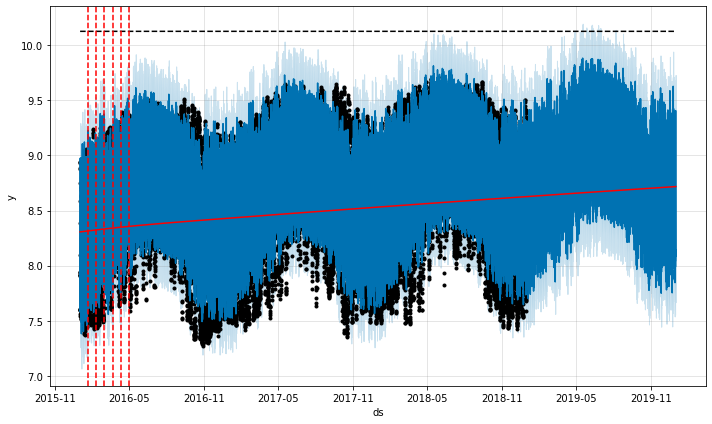

In [24]:
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)
forcast.tail()

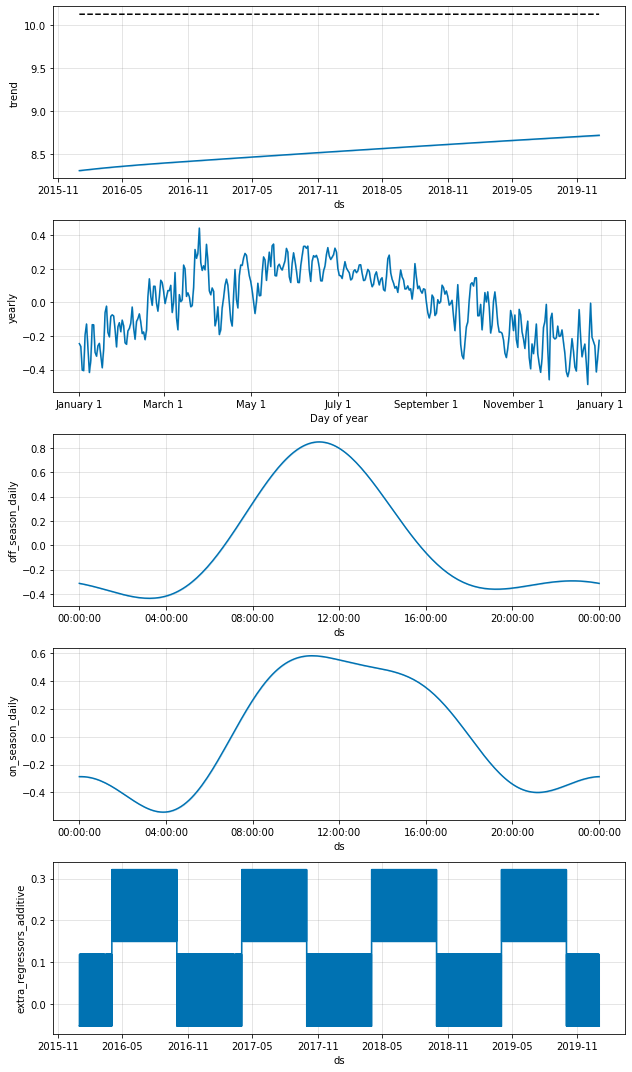

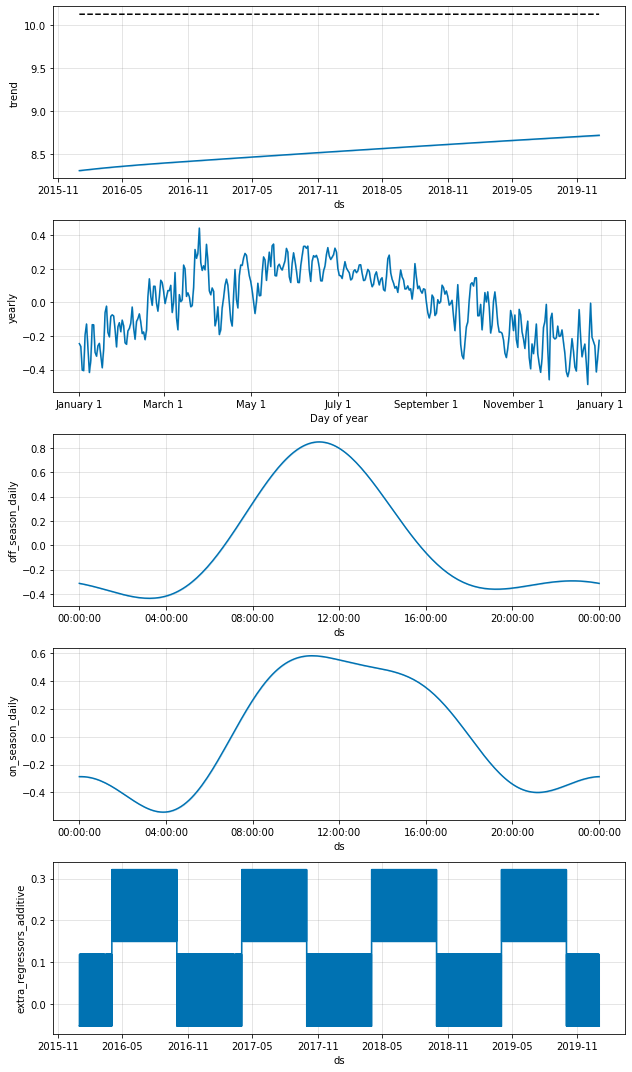

In [25]:
model.plot_components(forcast)

In [26]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

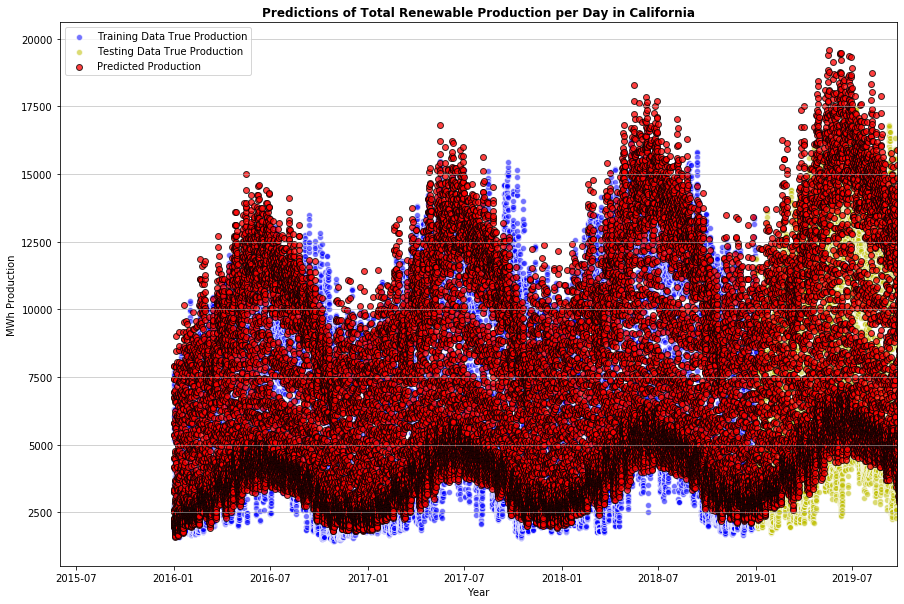

In [27]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  51545.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3258.0


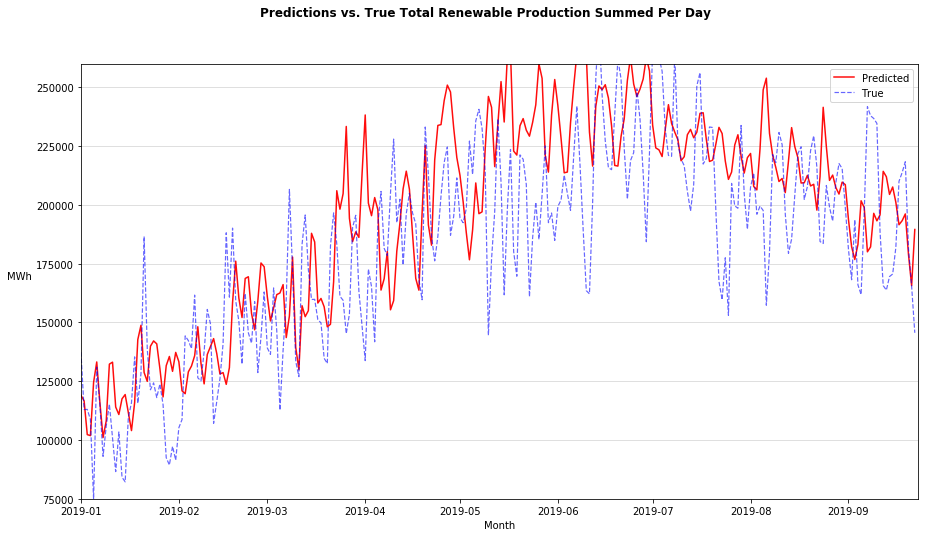

Train MAPE:  19.15697753571003
Train R2:  0.8620782172941612
Test MAPE:  23.484768977670228
Test R2:  0.7895219100026772


In [28]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'yhat'].values


datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('24H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[\
                                  (dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/np.nan_to_num(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [29]:
forcast['solar'] = forcasts['yhat']
predictions = forcast.loc[:,['ds','solar','yhat']]
predictions.rename(columns={
    'ds':'timestamp',
    'solar':'Pred Solar Prod',
    'yhat':'Pred Tot Renew Prod'
}, inplace=True)
predictions['Hour'] = predictions['timestamp'].dt.hour
predictions = predictions[['timestamp','Hour','Pred Tot Renew Prod','Pred Solar Prod']]
predictions.head(24)

timestamp  Hour  Pred Tot Renew Prod  Pred Solar Prod
0  2016-01-01 00:00:00     0          2221.704348        -8.844595
1  2016-01-01 01:00:00     1          2127.548858        -9.451883
2  2016-01-01 02:00:00     2          2023.691710        -7.031421
3  2016-01-01 03:00:00     3          1960.549607        -9.868032
4  2016-01-01 04:00:00     4          1991.603628        -5.453305
5  2016-01-01 05:00:00     5          2173.137197        -9.065528
6  2016-01-01 06:00:00     6          2570.631469         0.183324
7  2016-01-01 07:00:00     7          3254.804998       672.466490
8  2016-01-01 08:00:00     8          4508.130710      2835.440671
9  2016-01-01 09:00:00     9          5790.891252      3846.053762
10 2016-01-01 10:00:00    10          6931.354909      4606.222397
11 2016-01-01 11:00:00    11          7437.013442      4529.409050
12 2016-01-01 12:00:00    12          7913.066477      4696.835925
13 2016-01-01 13:00:00    13          6745.936034      4501.870638
14 2016-01-01 14:00:00    14          5368.926783      3969.161082
15 2016-01-01 15:00:00    15          4190.187518      2736.482587
16 2016-01-01 16:00:00    16          3356.344629       500.079800
17 2016-01-01 17:00:00    17          2538.289811         6.057879
18 2016-01-01 18:00:00    18          2304.290653        -0.007548
19 2016-01-01 19:00:00    19          2225.177038        -0.952253
20 2016-01-01 20:00:00    20          2118.957823        -2.650103
21 2016-01-01 21:00:00    21          2179.064050        -1.583512
22 2016-01-01 22:00:00    22          2235.368799        -2.944965
23 2016-01-01 23:00:00    23          2250.529071        -2.289538

In [30]:
# name = 'hourlyrenewablepredictions'
# schema = 'Predictions'

# with engine.connect() as c:
#     c.execute('''CREATE SCHEMA "Predictions"''')

# predictions.to_sql(name=name, con=con, schema=schema, if_exists='replace',index=False)

In [31]:
# with engine.connect() as c:
#     c.execute('''ALTER TABLE "Predictions".hourlyrenewablepredictions 
#     ADD PRIMARY KEY ("timestamp")''')

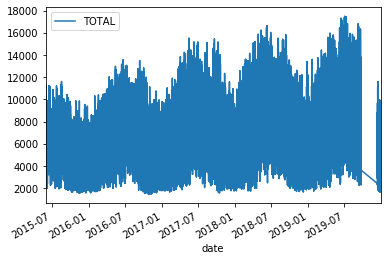

In [32]:
full_data.plot(x='date',
              y='TOTAL')

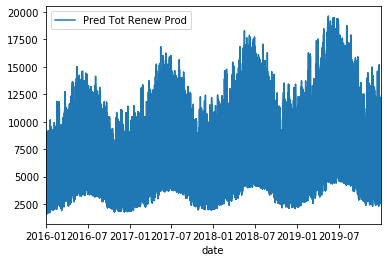

In [33]:
predictions['date'] = pd.to_datetime(predictions['timestamp']).dt.date
predictions.plot(x='date',
              y='Pred Tot Renew Prod')

In [34]:
from sklearn.metrics import mean_absolute_error as MAE
#train Mean Absolute Error 
MAE(tester_train['y'], tester_train['yhat'])

1006.3656495451198

In [35]:
#test mae
MAE(tester['y'], tester['yhat'])

1431.0636388487264

Predicted Total Renewable Production 2019:  51545.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3258.0


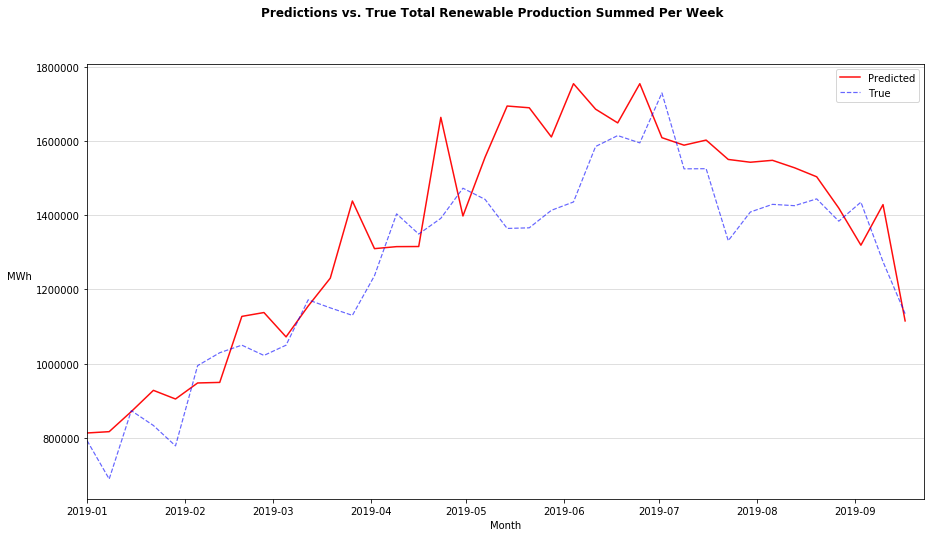

In [36]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('7D').sum().loc[:,'yhat'])


datat = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('7D').sum().loc[:,'y'])



month_list = pd.date_range('01/01/2019','09/23/2019',freq='1M')


plt.figure(figsize=(15,8))
plt.plot(dataf.index,dataf.reset_index()['yhat'],label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(datat.index,datat.reset_index()['y'],label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Week',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
# plt.ylim(bottom=75000,top=260000)
plt.show()




(50000, 278485.60428302974)

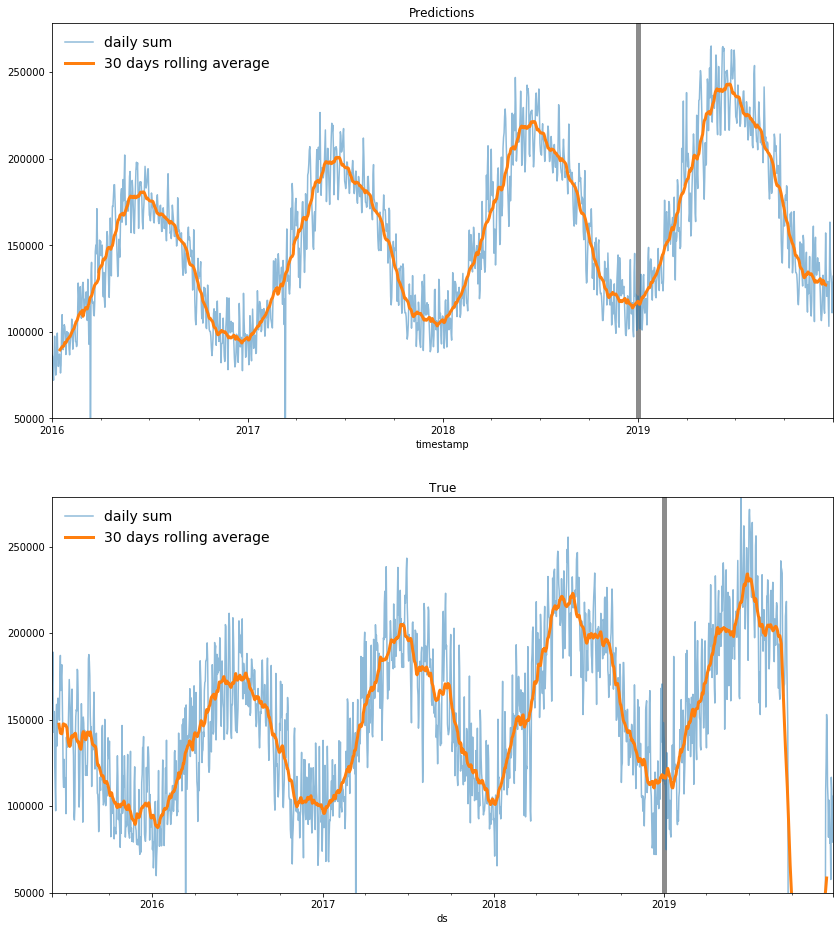

In [37]:
data = pd.DataFrame(predictions['Pred Tot Renew Prod']).set_index(pd.DatetimeIndex(predictions['timestamp'])).resample('1D').sum()
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(nrows=2, figsize=(14,16), sharey=True)

ax = axes[0]

data.plot(ax=ax, alpha=0.5, title="Predictions")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)

ax = axes[1]

data = pd.DataFrame(dd['y']).set_index(pd.DatetimeIndex(dd['ds'])).resample('1D').sum()
data.plot(ax=ax, alpha=0.5, title="True")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)


Text(-12000, 20000, 'R2: 0.79')

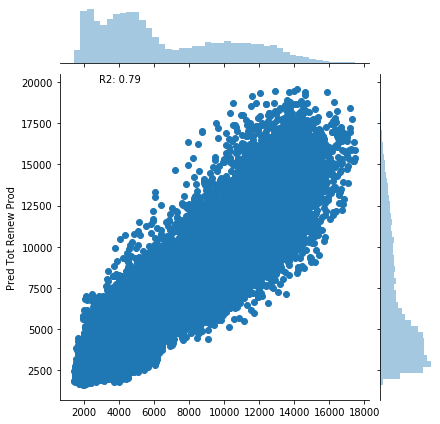

In [38]:
sns.jointplot(x=full_data.loc[((full_data['date'] >= pd.to_datetime('01/01/2016'))&\
                               (full_data['date'] < pd.to_datetime('09/23/2019'))),'TOTAL']\
              .values,y=predictions.loc[predictions['timestamp'] < pd.to_datetime('09/23/2019'),
                                                                                         'Pred Tot Renew Prod'])


plt.text(-12000,20000,s='R2: {}'.format(round(r2,3)))

# Now Building Demand Predictions 

In [220]:
sql_demand = '''SELECT * FROM "Demand".hourlydemand;'''

demand_df = pd.read_sql(sql=sql_demand, con=con)
demand_df.head()

timestamp        date  Hour   DEMAND
0 2019-12-29 11:00:00  2019-12-29    11  21305.0
1 2019-12-29 10:00:00  2019-12-29    10  21638.0
2 2019-12-29 09:00:00  2019-12-29     9  21745.0
3 2019-12-29 08:00:00  2019-12-29     8  21859.0
4 2019-12-29 07:00:00  2019-12-29     7  21586.0

In [221]:
demand_df = demand_df.set_index(pd.DatetimeIndex(demand_df['timestamp']))

y = demand_df['DEMAND']

daily_demand = y
dd_demand = pd.DataFrame(daily_demand).reset_index()

def demand_onS(ds):
    data = pd.to_datetime(ds)
    return (data.dayofyear > 90 & data.dayofyear < 320)
    
    
dd_demand.columns = ['ds','y']

dd_demand['cap'] = np.log(42000)

dd_demand['y'] = np.log(dd_demand['y'])
dd_demand['on_season'] = dd_demand['ds'].apply(demand_onS)
dd_demand['off_season'] = ~ dd_demand['ds'].apply(demand_onS)
dd_demand_train = pd.DataFrame(dd_demand.loc[((dd_demand['ds'] < pd.to_datetime('01/01/2019')))])
dd_demand_train.tail()

ds          y        cap  on_season  off_season
39362 2015-07-01 05:00:00  10.152728  10.645425       True       False
39363 2015-07-01 04:00:00  10.180665  10.645425       True       False
39364 2015-07-01 03:00:00  10.218882  10.645425       True       False
39365 2015-07-01 02:00:00  10.274672  10.645425       True       False
39366 2015-07-01 01:00:00  10.357298  10.645425       True       False

ds      trend        cap  yhat_lower  yhat_upper  \
39471 2019-12-31 19:00:00  10.103273  10.645425   10.064403   10.351682   
39472 2019-12-31 20:00:00  10.103270  10.645425   10.065376   10.358359   
39473 2019-12-31 21:00:00  10.103267  10.645425   10.036541   10.347273   
39474 2019-12-31 22:00:00  10.103265  10.645425   10.009325   10.312801   
39475 2019-12-31 23:00:00  10.103262  10.645425    9.951216   10.237575   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
39471     9.981806    10.210555        0.115454              0.115454   
39472     9.981781    10.210582        0.113197              0.113197   
39473     9.981757    10.210609        0.098913              0.098913   
39474     9.981733    10.210636        0.062499              0.062499   
39475     9.981708    10.210663       -0.004098             -0.004098   

       additive_terms_upper  ...    weekly  weekly_lower  weekly_upper  \
39471              0.115454  ...  0.028107      0.028107      0.028107   
39472              0.113197  ...  0.027864      0.027864      0.027864   
39473              0.098913  ...  0.027691      0.027691      0.027691   
39474              0.062499  ...  0.027589      0.027589      0.027589   
39475             -0.004098  ...  0.027558      0.027558      0.027558   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
39471 -0.079307     -0.079307     -0.079307                   0.0   
39472 -0.079956     -0.079956     -0.079956                   0.0   
39473 -0.080606     -0.080606     -0.080606                   0.0   
39474 -0.081258     -0.081258     -0.081258                   0.0   
39475 -0.081911     -0.081911     -0.081911                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper       yhat  
39471                         0.0                         0.0  10.218727  
39472                         0.0                         0.0  10.216467  
39473                         0.0                         0.0  10.202181  
39474                         0.0                         0.0  10.165763  
39475                         0.0                         0.0  10.099163  

[5 rows x 26 columns]

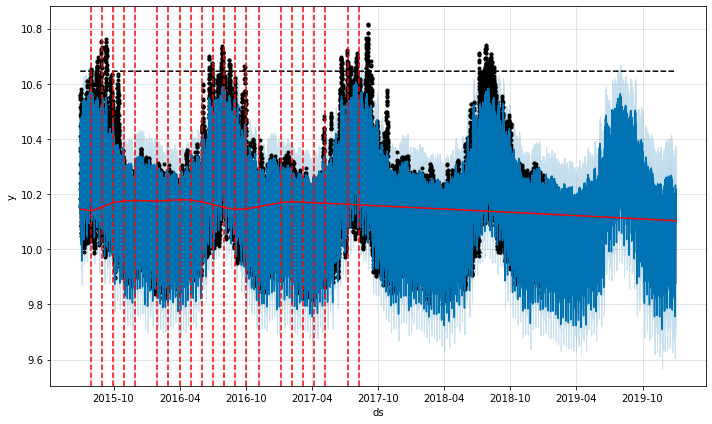

In [222]:
model = Prophet(changepoint_range=.6,weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=50,
               growth='logistic')

model.add_seasonality(name='on_season_daily',period=1, condition_name='on_season',fourier_order=10,prior_scale=10)
model.add_seasonality(name='off_season_daily',period=1, condition_name='off_season',fourier_order=10,prior_scale=10)

model.fit(dd_demand_train)

future = model.make_future_dataframe(periods=365*24,freq='1H')
future['cap'] = np.log(42000)
future['on_season'] = future['ds'].apply(demand_onS)
future['off_season'] = ~ future['ds'].apply(demand_onS)
forcast = model.predict(future)

fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)
forcast.tail()

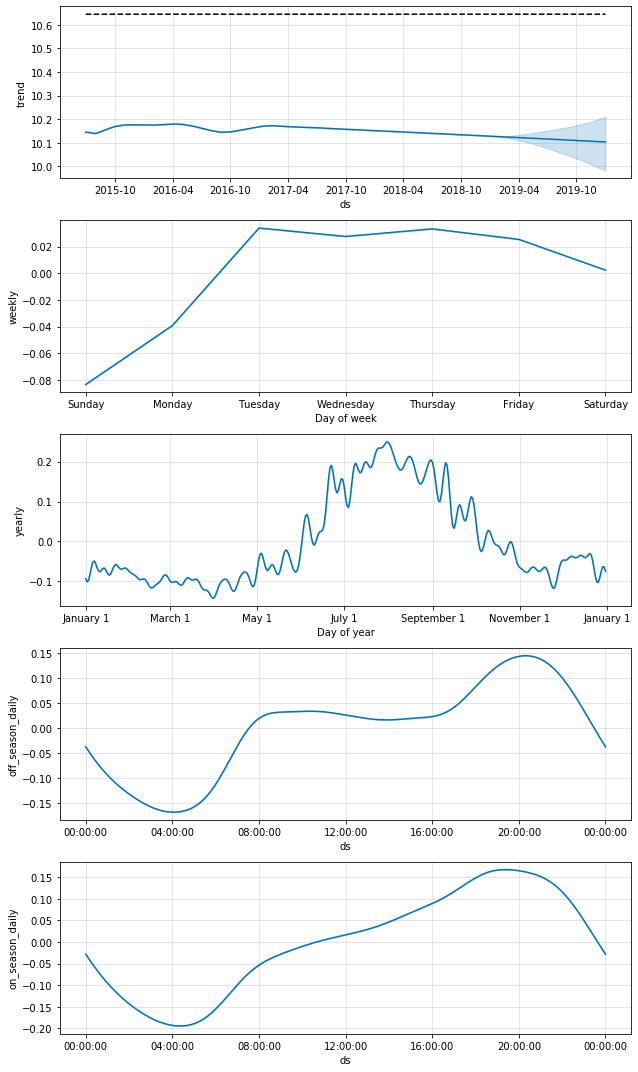

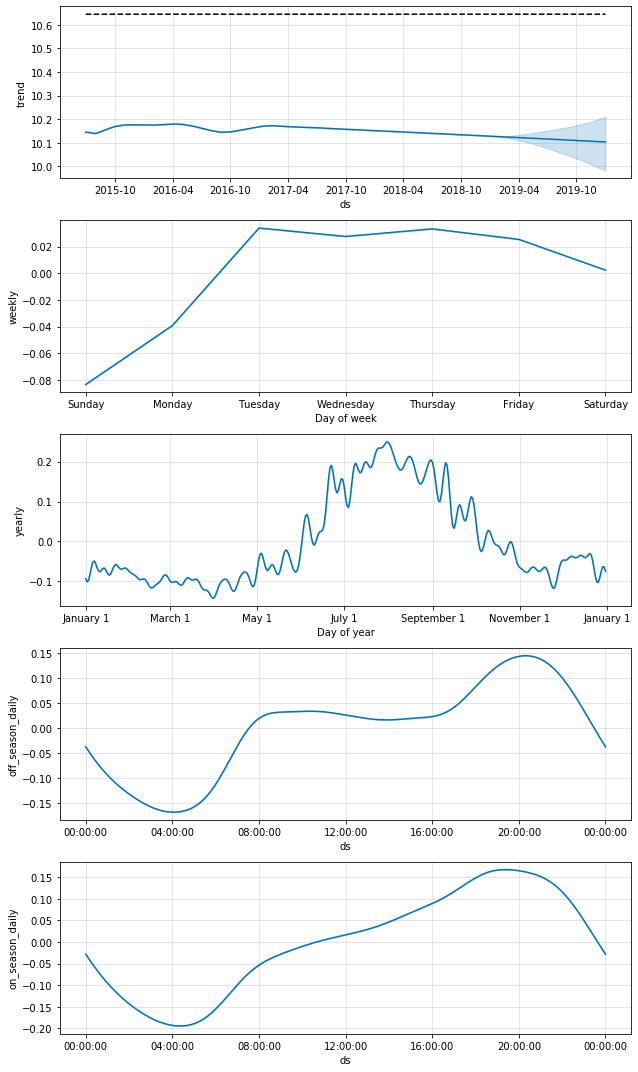

In [223]:
model.plot_components(forcast)

In [224]:
dd_demand['y'] = np.exp(dd_demand['y'])

dd_demand_train['y'] = np.exp(dd_demand_train['y'])

forcast['yhat'] = np.exp(forcast['yhat'])

dd_demand_test = dd_demand.loc[dd_demand['ds']>pd.to_datetime('01/01/2019')]



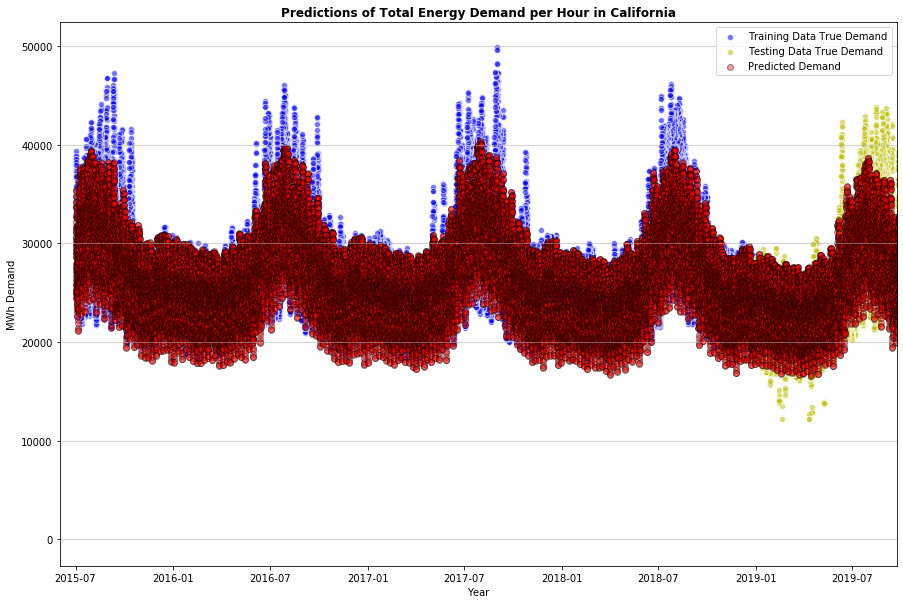

In [225]:

plt.figure(figsize=(15,10))

plt.scatter(dd_demand_train['ds'],dd_demand_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Demand')
plt.scatter(dd_demand_test['ds'],dd_demand_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Demand')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.4,edgecolor='k',label='Predicted Demand')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Demand')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Energy Demand per Hour in California",fontweight='bold')
plt.show()



Predicted Total Demand 2019 (GWh):  210681.0
True Total Energy Demand 2019 (GWh):  202123.0
Error (GWh):  8558.0
Percent Error:  4.2 %


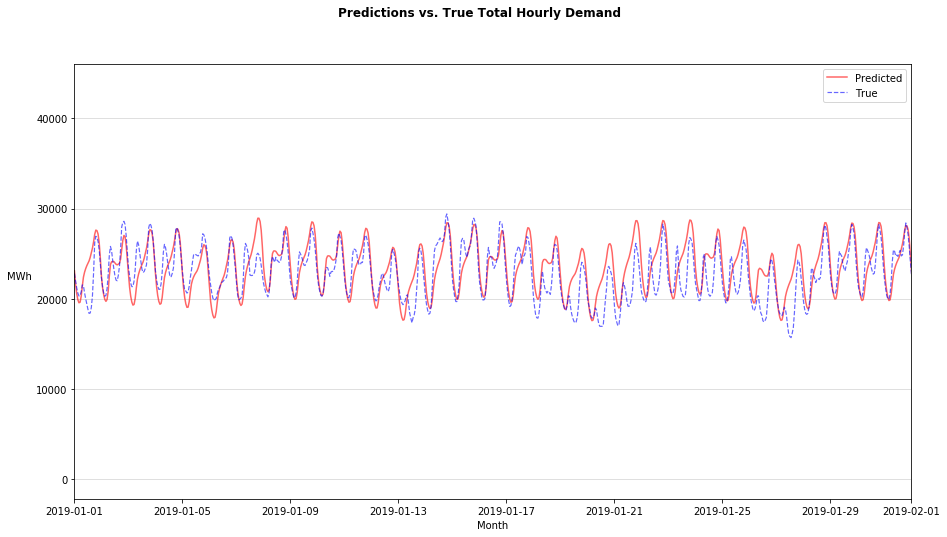

Train MAPE:  5.54 %
Train R2:  0.8260490305997523
Test MAPE:  8.48 %
Test R2:  0.7051000420598019


In [226]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('12/16/2019'))),['yhat','ds']])
true = pd.DataFrame(dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Demand 2019 (GWh): ',(tester['yhat'].sum())//1000)
print('True Total Energy Demand 2019 (GWh): ',tester['y'].sum()//1000)
print('Error (GWh): ', (tester['yhat'].sum()-tester['y'].sum())//1000)
print('Percent Error: ', round(((tester['yhat'].sum()-tester['y'].sum())/tester['y'].sum())*100,1),'%')


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('12/16/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('12/16/2019'))),'ds'])).\
resample('1H').sum().loc[:,'yhat'].values


datat = dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),:].set_index\
(pd.DatetimeIndex(dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),'ds'])).resample('1H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','12/15/2019 23:00:00',freq='1H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.6,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Hourly Demand',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('02/01/2019'))

plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd_demand.loc[\
                                  (dd_demand['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
index = []
for ind,j in enumerate(true_train):
    if np.isnan(j):
        index.append(ind)
true_train, yhat_train = np.delete(true_train, index), np.delete(yhat_train, index)
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', round(mape,2),'%')
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values

yhat_test = tester['yhat'].values
indexes = []
for ind,j in enumerate(true_test):
    if np.isnan(j):
        indexes.append(ind)

yhat_test = np.delete(yhat_test, indexes)
true_test = np.delete(true_test, indexes)
        
        

mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', round(mape2,2),'%')

print('Test R2: ',r2)
